In [1]:
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
import numpy as np
import pickle

from time import perf_counter

## 1) Low Rank Approximation

We begin by briefly summarising how the four methods used in this lab can be used to obtain low rank approximations of our data. In this lab we will be working with images, where each pixel is encoded by four values, namely RGBA (red, green, blue, alpha). These four dimensions encoding each pixel will be referred to as the four channels of our images. You should create low rank approximations separately for each channel, i.e., to obtain a low rank approxiamtion for the images, you should separately calculate the low rank approximation for each channel of the input image and then concatinate these low rank approximations. Therefore, in this lab our data  will be denoted by $X_i \in R^{n\times m}$ for $i \in \{R,G,B,A\}.$ 



**PCA:** Let $M_i\in R^{n\times m} $ be the matrix containing the column means of $X_i$ in each column. Further, let $C_i = X_i -  M_i$ denote the data matrix $X_i,$ where the column mean is substracted from each column. Furthermore, let $U_k\in R^{m\times k}$ denote the right singular vectors of $C_i$ corresponding to the largest $k$ singular values. Then, the PCA low-rank approximation, denoted $\tilde{X}_i^{PCA},$ of $X_i$ is obtained as follows,
\begin{equation}
\tilde{X}_i^{PCA} = C_i U_k U_k^T + M.
\end{equation}


**SVD:** Consider the singular value decomposition of $X_i = V \Sigma W^T.$ Further, let $V_k \in R^{n\times k},$ $W_k \in R^{m\times k}$ and $\Sigma_k \in R^{k\times k}$ contain the first $k$ left and right singular vectors and the largest $k$ singular values, respectivly. Then, the singular value low rank approximation, denoted $\tilde{X}_i^{SVD},$ of $X_i$ is obtained as follows,
\begin{equation}
\tilde{X}_i^{SVD} = V_k \Sigma_k W_k^T.
\end{equation}


**NMF:** The non-negative matrix factorisation is iteratively calculated and directly produces a low rank approximation of $X_i$ into factors denoted by $A \in R^{n \times k}$ and $B\in R^{k \times m}.$ Hence,   
\begin{equation}
\tilde{X}_i^{NMF} = AB.
\end{equation}

**MDS:** 
Let $M_i\in R^{n\times m} $ be the matrix containing the column means of $X_i$ in each column. Further, let $C_i = X_i -  M_i$ denote the data matrix $X_i,$ where the column mean is substracted from each column. 
For the multidimensional scaling algorithm we utilise the singular value decomposition of the matrix denoted $C_i C_i^T.$ Let $Q_k \in R^{n\times k}$ denote the matrix containing the $k$ singular vectors corresponding to the $k$ largest singluar values of $C_i C_i^T.$ Then, the low rank approximation, denoted $\tilde{X}_i^{MDS},$ of $X_i$ is obtained as follows,
\begin{equation}
\tilde{X}_i^{MDS} =  Q_k Q_k^T C_i +M_i.
\end{equation}

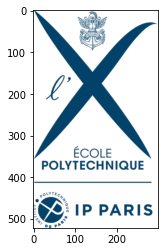

(522, 300, 4)


In [2]:
logo = mpimg.imread('IPPX_logo.png') 
plt.imshow(logo) 
plt.show()

logo = np.array(logo)
print(logo.shape)
# split color channel
# logo_r = logo[:,:,0]
# logo_g = logo[:,:,1]
# logo_b = logo[:,:,2]
# logo_a = logo[:,:,3]

In [3]:
def pca(X, k):
    """
    Args:
        X (np.array, dim: n,m,4): containing the image channel to be processed
        k (int): the number of elements to be used in the low rank approximation 
    
    Returns:
        X_low_rank_approx (np.array, dim: n,m,4): low rank approximation of X
        U (np.array, dim: m,k,4): singular vectors used to obtain the low rank approximation
    """
    
    #Please insert the code for Task 1 here
    
    x_low_rank_approx_lst = []
    u_lst = []
    
    for i in range(0,4):
        x = X[:,:,i]
        m = np.mean(x, axis=0)
        c = x - m
        eigVal, eigVec = np.linalg.eigh(c.T @ c)
        idx = np.argsort(-eigVal)[:k]
        u = eigVec[:, idx]
        x_low_rank_approx = c @ u @ u.T + m
        
        x_low_rank_approx_lst.append(x_low_rank_approx)
        u_lst.append(u)
        
    X_low_rank_approx = np.stack(x_low_rank_approx_lst, axis=-1)
    U = np.stack(u_lst, axis=-1)

    return X_low_rank_approx, U



def svd(X, k):
    """
    Args:
        X (np.array, dim: n,m,4): containing the image channel to be processed
        k (int): the number of elements to be used in the low rank approximation 
    
    Returns:
        X_low_rank_approx (np.array, dim: n,m,4): low rank approximation of X
    """
    
    #Please insert the code for Task 1 here
    
    x_low_rank_approx_lst = []
    
    for i in range(0,4):
        x = X[:,:,i]
        
        # right singular vectors w
        eigVal, eigVect = np.linalg.eigh(x.T @ x)
        idx = np.argsort(-eigVal)
        eigVal = eigVal[idx]
        w = eigVect[:,idx]
        
        # singular values
        s = list(map(lambda a: np.sqrt(a) if a>0 else 0, eigVal))
        s = np.array(s)
        sigma = np.diag(s)
        sigma = sigma[0:k, 0:k]

        # left singular vectors v
        v = np.zeros((x.shape[0], k))
        for i in range(k):
            v[:,i] = np.transpose( x @ w[:,i] / s[i] )

        w = w[:,0:k]
        x_low_rank_approx =  v @ sigma @ w.T
        
        x_low_rank_approx_lst.append(x_low_rank_approx)

    X_low_rank_approx = np.stack(x_low_rank_approx_lst, axis=-1)
    
    return X_low_rank_approx



def nmf(X, k, max_iter = 100, E = 10**(-4)):
    """
    Args:
        X (np.array, dim: n,m,4): containing the image channel to be processed
        k (int): the number of elements to be used in the low rank approximation 
    
    Returns:
        X_low_rank_approx (np.array, dim: n,m,4): low rank approximation of X
    """
    
    #Please insert the code for Task 1 here    
    
    x_low_rank_approx_lst = []
    n, m, _ = X.shape

    for i in range(0,4):
        x = X[:,:,i]
        
        A = np.array(np.random.rand(n, k))
        B = np.array(np.random.rand(m, k))

        for iter in range(max_iter):
            # update U
            temp = A @ B.T @ B
            A = A * (x @ B / np.maximum(temp, E))
            
            # update V
            temp = B @ B.T @ B
            B = B * (x.T @ A / np.maximum(temp, E))
            D = np.diag(1 / np.maximum(np.sqrt(np.sum(B*B,0)), E)).astype(np.float32)
            B = B @ D

            e = x - A @ B.T
            error = np.sum(e**2)

            if error<E:
                break

        x_low_rank_approx = A @ B.T
        
        x_low_rank_approx_lst.append(x_low_rank_approx)
        
    X_low_rank_approx = np.stack(x_low_rank_approx_lst, axis=-1)

    
    return X_low_rank_approx



def mds(X, k):
    """
    Args:
        X (np.array, dim: n,m,4): containing the image channel to be processed
        k (int): the number of elements to be used in the low rank approximation 
    
    Returns:
        X_low_rank_approx (np.array, dim: n,m,4): low rank approximation of X
    """
    
    #Please insert the code for Task 1 here
    
    x_low_rank_approx_lst = []

    for i in range(0,4):
        x = X[:,:,i]
        m = np.mean(x, axis=0)
        c = x - m
        
        eigVal, eigVec = np.linalg.eigh(c @ c.T)
        idx = np.argsort(-eigVal)[:k]
        q = eigVec[:, idx]
        x_low_rank_approx = q @ q.T @ c + m
        
        x_low_rank_approx_lst.append(x_low_rank_approx)
        
    X_low_rank_approx = np.stack(x_low_rank_approx_lst, axis=-1)

    return X_low_rank_approx

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

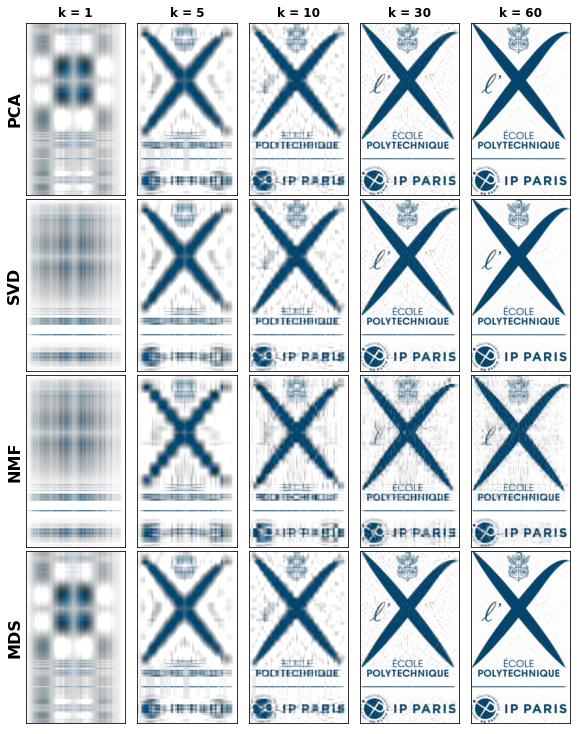

In [4]:
k_values = [1,5,10,30,60]
results_task2 = np.zeros(logo.shape + tuple([20]))


#Please insert the code for Task 2 here

fig, axs = plt.subplots(4,5, figsize=(8,10))


titles = ['k = 1','k = 5','k = 10','k = 30','k = 60']
methods = ['PCA', 'SVD', 'NMF', 'MDS']
for i in range(4):
    axs[i,0].set_ylabel(methods[i], fontsize=16,fontweight='bold')
    for j in range(5):
        if i == 0:
            axs[i,j].set_title(titles[j], fontweight='bold')
            img,u = pca(logo, k_values[j])
        elif i == 1:
            img = svd(logo, k_values[j])
        elif i == 2:
            img = nmf(logo, k_values[j])
        elif i == 3:
            img = mds(logo, k_values[j])
            
        axs[i,j].imshow(np.clip(results_task2[:,:,:,i*5+j],0,1))
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        
        axs[i,j].imshow(img.astype(np.float32))
        
fig.tight_layout(pad=0)


The quality of the PCA reconstruction is often evaluated by calculating the fraction of the total variance of the image that is preserved in the reconstructed image. Hence, the first evaluation metric we want to use to assess the quality of the reconstruction is the sum of the eigenvalues of the estimated covariance matrix $(\tilde{C}_i^{h})^T \tilde{C}_i^{h}/n$ for $h \in \{\text{PCA, SVD, NMF, MDS}\}$ divided by the sum of eigenvalues of the estimated covariance matrix of the original image $C_i^T C_i/m.$ The final metric is produced by averaging the fraction of the sum of eigenvalues over all four image channels.

The MDS algorithm minimises the *Stress* metric, which is calculated as follows,
\begin{equation}
    Stress = \sqrt{\dfrac{\sum_{a=1}^n \sum_{b=1}^n (d_{ab} - \delta_{ab})^2}{\sum_{a=1}^n \sum_{b=1}^n \delta_{ab}^2}},
\end{equation} 
where $d_{ab}$ the Euclidian distance between rows $a$ and $b$ of matrix $\tilde{X}_i^{h}$ for $h \in \{\text{PCA, SVD, NMF, MDS}\}$ and $\delta_{ab}$ contains the Euclidian distance between rows $a$ and $b$ of $X_i$. Again the final metric is produced by averaging the Stress metric over all four image channels.

The performance of the SVD and NMF reconstruction is commonly measured using the difference of the original image and the reconstructed image in Frobenius norm. This will be the third metric we will consider to compare our low rank approximations.

In [5]:
def evals(X, X_low_rank_approx):
    """
    Args:
        X (np.array, dim: n,m,4): containing the image channel to be processed
        X_low_rank_approx (np.array, dim: n,m,4): low rank approximation of X
    Returns:
        eval_fraction (float): the ratio of the explained variance as described in the problem description
    """
    
    #Please insert the code for Task 3 here
    
    eval_fraction_sum = 0
    for i in range(0,4):
        x = X[:,:,i]
        x_low_rank_approx = X_low_rank_approx[:,:,i]
        
        eigVal, _ = np.linalg.eigh(x_low_rank_approx.T @ x_low_rank_approx)
        eigVal_origin, _ = np.linalg.eigh(x.T @ x)
        
        eval_fraction_sum += sum(eigVal) / sum(eigVal_origin)
        
    eval_fraction = eval_fraction_sum / 4
    return eval_fraction


def stress(X, X_low_rank_approx):
    """
    Args:
        X (np.array, dim: n,m,4): containing the image channel to be processed
        X_low_rank_approx (np.array, dim: n,m,4): low rank approximation of X
    Returns:
        stress (float): the stress metric value
    """
    
    #Please insert the code for Task 3 here
    
    stress_sum = 0
    
    for i in range(0,4):
        x = X[:,:,i]
        x_low_rank_approx = X_low_rank_approx[:,:,i]
        n = x.shape[0]
        sum1 = 0
        sum2 = 0
        for a in range(0,n):
            for b in range(0,n):
                d = np.linalg.norm(x_low_rank_approx[a,:] - x_low_rank_approx[b,:])
                d_origin = np.linalg.norm(x[a,:] - x[b,:])
                sum1 += (d - d_origin)**2
                sum2 += d_origin**2

        stress_sum += np.sqrt(sum1/sum2)
        
    stress = stress_sum/4
    
    return stress


def Fnorm_difference(X, X_low_rank_approx):
    """
    Args:
        X (np.array, dim: n,m,4): containing the image channel to be processed
        X_low_rank_approx (np.array, dim: n,m,4): low rank approximation of X
    Returns:
        diff (float): the difference of the two inputs in Frobenius norm
    """
    
    #Please insert the code for Task 3 here
    
    diff_sum = 0
    
    for i in range(0,4):
        x = X[:,:,i]
        x_low_rank_approx = X_low_rank_approx[:,:,i]
        
        # diff_sum += np.linalg.norm(x,ord='fro') - np.linalg.norm(x_low_rank_approx,ord='fro')
        diff_sum += np.linalg.norm((x - x_low_rank_approx),ord='fro')
        
        
    diff = diff_sum/4
    
    return diff



In [6]:
results_task3 = np.zeros(shape=[4,3])

#Please insert the code for Task 3 here to fill the results matrix


metrics = ['evals', 'stress', 'norm']
methods = ['PCA', 'SVD', 'NMF', 'MDS']

print('\t',end='')
for j in range(3):
    print(metrics[j], end='\t')
print('')

for i in range(4):
    print(methods[i], end='\t')
    
    if i == 0:
        X_low_rank_approx,_ = pca(logo, 10)
    elif i == 1:
        X_low_rank_approx = svd(logo, 10)
    elif i == 2:
        X_low_rank_approx = nmf(logo, 10)
    elif i == 3:
        X_low_rank_approx = mds(logo, 10)
    
    for j in range(3):
        
        if j == 0:
            results_task3[i,j] = evals(logo, X_low_rank_approx)
        elif j == 1:
            results_task3[i,j] = stress(logo, X_low_rank_approx)
        elif j == 2:
            results_task3[i,j] = Fnorm_difference(logo, X_low_rank_approx)
            
        print(np.round(results_task3[i,j],4),'\t', end='')
    print('')

	evals	stress	norm	
PCA	0.7822 	0.1951 	32.1213 	
SVD	0.7814 	0.1957 	32.202 	
NMF	0.7369 	0.2852 	36.6476 	
MDS	0.7822 	0.1951 	32.1213 	


## 2) Orthogonal Transformation of the Input Data

Now we will work with another image, which was obtained from the logo we have been working with so far, by applying a random orthogonal transformation to the pixel values. Hence, if $X_i$ contains the pixel values in the $i^{\mathrm{th}}$ channel of the original image and  $X_i'$ contains the pixel values in the $i^{\mathrm{th}}$ channel of the transformed image, then they are related as follows,
$$
X_i' = X_i Q \qquad ~ \qquad \forall i,
$$
where $Q$ is an orthogonal matrix which was randomly sampled.

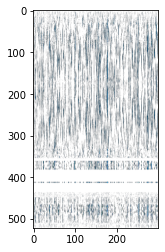

In [7]:
with open('transformed_image.pickle', 'rb') as f:
    transformed_image = pickle.load(f)
    # transformed_image = np.clip(transformed_image,0,1)
    
plt.imshow(np.clip(transformed_image,0,1))
plt.show()

In [8]:
results_task4 = np.zeros(shape=[4,3])

#Please insert the code for Task 4 here to fill the results matrix

metrics = ['evals', 'stress', 'norm']
methods = ['PCA', 'SVD', 'NMF', 'MDS']

print('\t',end='')
for j in range(3):
    print(metrics[j], end='\t')
print('')

for i in range(4):
    print(methods[i], end='\t')

    if i == 0:
        X_low_rank_approx,_ = pca(transformed_image, 10)
    elif i == 1:
        X_low_rank_approx = svd(transformed_image, 10)
    elif i == 2:
        X_low_rank_approx = nmf(transformed_image, 10)
    elif i == 3:
        X_low_rank_approx = mds(transformed_image, 10)
    
    for j in range(3):
        
        if j == 0:
            results_task4[i,j] = evals(transformed_image, X_low_rank_approx)
        elif j == 1:
            results_task4[i,j] = stress(transformed_image, X_low_rank_approx)
        elif j == 2:
            results_task4[i,j] = Fnorm_difference(transformed_image, X_low_rank_approx)
        
        print(np.round(results_task4[i,j],4),'\t', end='')
    print('')
    

	evals	stress	norm	
PCA	0.7822 	0.1951 	32.1213 	
SVD	0.7814 	0.1957 	32.202 	
NMF	0.0 	1.0 	79.823 	
MDS	0.7822 	0.1951 	32.1213 	


## 3) Image Denoising

In this section we will use the eigenvectors used in the PCA of the original logo to denoise two noisy images of the logo. In the cell below we load the two noisy images.

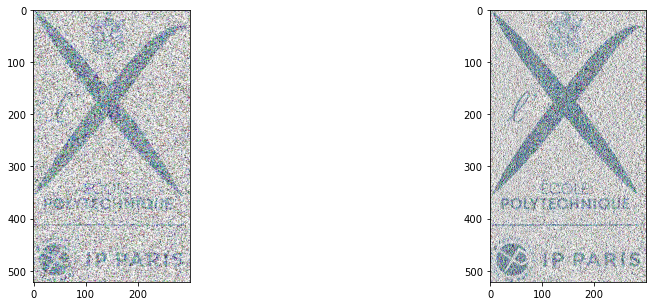

In [9]:
with open('noisy_image1.pickle', 'rb') as f:
    noisy_image1 = pickle.load(f)
    
with open('noisy_image2.pickle', 'rb') as f:
    noisy_image2 = pickle.load(f)
    
fig, axs = plt.subplots(1,2, figsize=(15,5))  
axs[0].imshow(np.clip(noisy_image1,0,1))
axs[1].imshow(np.clip(noisy_image2,0,1))
plt.show()

In [10]:
#Please insert the code for Task 5 here

def denoiseImage(noisy_image, original_image):
    """
    Denoise noisy_image using the eigenvectors of the original_image
    
    Args:
        noisy_image (np.array, dim: n,m,4)
        original_image (np.array, dim: n,m,4)
    Returns:
        k_optimal (int): the best number of eigenvectors which minmises the Frobenius norm
        denoised_image (np.array, dim: n,m,4)
    """
    k = 1
    k_optimal = 1
    fnorm_min = Fnorm_difference(noisy_image, original_image)
    
    while True:
        _, U_original = pca(original_image, k)    # u of original image
        x_denoised_lst = []
        for i in range(0,4):
            x = noisy_image[:,:,i]    # c of noisy image
            m = np.mean(x, axis=0)
            c = x - m
            
            u = U_original[:,:,i]
            x_denoised = c @ u @ u.T + m
            x_denoised_lst.append(x_denoised)

        denoised_image = np.stack(x_denoised_lst, axis=-1)

        fnorm = Fnorm_difference(denoised_image, original_image)
        # print('k:', k , ', fnorm:', fnorm)
        
        if fnorm <  fnorm_min:
            fnorm_min = fnorm
            k_optimal = k
            k = k + 1
        else:
            break
    
    print('k_optimal:',  k_optimal)
    print('--------------------')
    
    return k_optimal, denoised_image

k_optimal: 3
--------------------
k_optimal: 75
--------------------


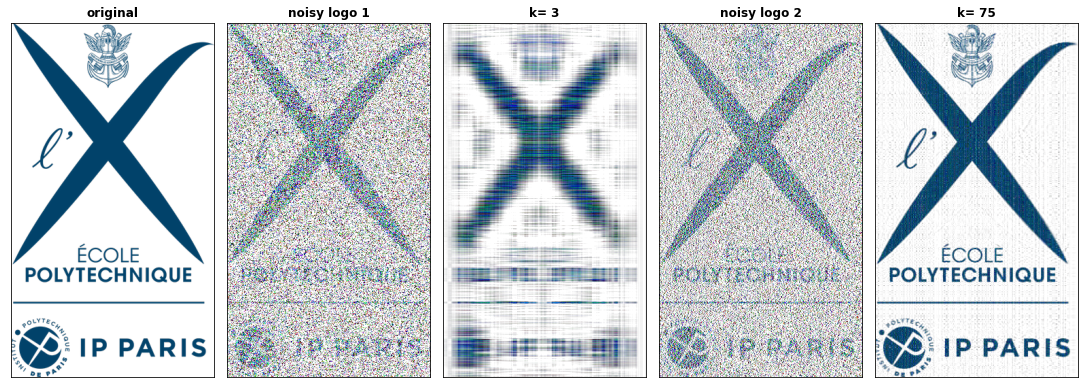

In [11]:
#Please insert the code for Task 5 here

denoised_image1 = np.zeros(logo.shape)
denoised_image2 = np.zeros(logo.shape)

n,m,D = logo.shape

k1_optimal, denoised_image1 = denoiseImage(noisy_image1, logo) #Please insert the code for Task 5 here
k2_optimal, denoised_image2 = denoiseImage(noisy_image2, logo) #Please insert the code for Task 5 here


fig, axs = plt.subplots(1,5, figsize=(15,5))    
axs[0].imshow(logo)
axs[1].imshow(np.clip(noisy_image1,0,1))
axs[2].imshow(np.clip(denoised_image1,0,1))
axs[3].imshow(np.clip(noisy_image2,0,1))
axs[4].imshow(np.clip(denoised_image2,0,1))


titles = ['original', 'noisy logo 1', 'k= %d'%(k1_optimal), 'noisy logo 2', 'k= %d'%(k2_optimal)]
for i in range(5):
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_title(titles[i], fontweight='bold')
fig.tight_layout(pad=0)